# Projeto com Feedback 12
### Data Science Academy

*Stefani Ramalho, 27 de novembro de 2019*

### Gas Sensor Array Drift Dataset Data Set*

fonte: https://archive.ics.uci.edu/ml/datasets/gas+sensor+array+drift+dataset

Com o avanço da tendência de IoT (Internet of Things) em todas as áreas de
negócios, a tecnologia nos permitiu ser capaz de lidar com uma grande
quantidade de dados ingeridos com alta velocidade.
Nosso caso de uso é um sistema de rede de dutos fictícios chamado
SmartPipeNet, que é uma rede de sensores com um sistema de controle de backoffice
que pode monitorar o fluxo da tubulação e reagir a eventos ao longo das
várias filiais para fornecer feedback de produção, detectar e reduzir reativamente
a perda e evitar acidentes. Seus principais recursos incluem:

• Detecção de vazamento.
• Regular os suprimentos para as várias cadeias do pipeline com base na
detecção de certos eventos.
• Alertas de manutenção preditiva.
• Regulação reativa do fluxo do pipeline, incluindo desligamento e reinício do
fluxo, também na detecção de eventos

Embora você deva dedicar tempo examinando a implementação tanto quanto
a arquitetura de IoT neste projeto, seu objetivo é construir o argumento para uma
arquitetura de streaming generalizada para ingestão de dados com base em uma
arquitetura de microservice.

In [1]:
# Importando os modulos
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Coletando os dados e agrupando para um unico dataset

In [2]:
# nomes de todos os datasets
datasets = os.listdir("dados/")

# Funcao para fazer a leitura do dataset
def ler_dados(x):
    dados = pd.read_table("dados/" + x, sep = " ", header = None)
    return dados

# dataset para receber os dados agrupados
df = pd.DataFrame()

# Loop para fazer a leitura dos dados
for item in datasets:
    dados = ler_dados(item)
    colunas = ["sen_" + str(i) for i in dados.columns[1:]]
    colunas.insert(0,"level")
    dados.columns = colunas
    dados.insert(0,"Batch",item)
    df = pd.concat([df, dados]).reset_index(drop = True)

In [3]:
# Remove os dois pontos antens de cada numero e converte para o tipo numerico
for item in np.arange(2,df.shape[1]):
    df.iloc[:,item] = df.iloc[:,item].str.split(":").str[1].astype("float")
    
# Convertendo o atributo target para o tipo fator
df.level = df.level.astype("category")

Explorando os dados

In [4]:
# Visualizando os dados
df.head()

,Batch,level,sen_1,sen_2,sen_3,sen_4,sen_5,sen_6,sen_7,sen_8,...,sen_119,sen_120,sen_121,sen_122,sen_123,sen_124,sen_125,sen_126,sen_127,sen_128
0,batch1.dat,1,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,...,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,batch1.dat,1,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,...,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225
2,batch1.dat,1,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,...,-2.384784,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370
3,batch1.dat,1,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,...,-2.607199,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957
4,batch1.dat,1,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,...,-3.594763,-4.181920,8158.6449,7.174334,1.993808,3.829303,4.402448,-1.930107,-2.931265,-4.088756


In [5]:
# Shape dos dados
df.shape

(13910, 130)

Nao foram encontrandos valores ausentes

In [7]:
# buscandi por valores missings
df.isnull().sum()

Batch      0
level      0
sen_1      0
sen_2      0
sen_3      0
sen_4      0
sen_5      0
sen_6      0
sen_7      0
sen_8      0
sen_9      0
sen_10     0
sen_11     0
sen_12     0
sen_13     0
sen_14     0
sen_15     0
sen_16     0
sen_17     0
sen_18     0
sen_19     0
sen_20     0
sen_21     0
sen_22     0
sen_23     0
sen_24     0
sen_25     0
sen_26     0
sen_27     0
sen_28     0
          ..
sen_99     0
sen_100    0
sen_101    0
sen_102    0
sen_103    0
sen_104    0
sen_105    0
sen_106    0
sen_107    0
sen_108    0
sen_109    0
sen_110    0
sen_111    0
sen_112    0
sen_113    0
sen_114    0
sen_115    0
sen_116    0
sen_117    0
sen_118    0
sen_119    0
sen_120    0
sen_121    0
sen_122    0
sen_123    0
sen_124    0
sen_125    0
sen_126    0
sen_127    0
sen_128    0
Length: 130, dtype: int64

Analise estatistica dos dados dos sensores

In [8]:
# Resumo estatistico
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sen_1,13910.0,50435.066174,69844.785952,-16757.598600,6694.725950,19364.439350,63104.837125,670687.347700
sen_2,13910.0,6.638156,13.486391,0.088287,2.284843,3.871227,8.400619,1339.879283
sen_3,13910.0,12.936688,17.610061,0.000100,1.633350,4.977123,17.189165,167.079751
sen_4,13910.0,18.743953,24.899450,0.000100,2.386836,7.250892,26.411109,226.619457
sen_5,13910.0,26.890695,38.107685,0.000100,4.967988,11.680725,34.843226,993.605306
sen_6,13910.0,-9.158655,12.729206,-131.332873,-11.587169,-3.338700,-1.126897,-0.006941
sen_7,13910.0,-14.402383,21.304606,-227.627758,-17.292559,-4.956917,-1.670327,22.201589
sen_8,13910.0,-59.927598,131.017675,-1664.735576,-48.492764,-14.040088,-5.212213,115.273147
sen_9,13910.0,57340.104585,64045.265134,-16119.460900,13287.301875,37764.263200,70300.782575,502202.812500
sen_10,13910.0,6.648033,15.585780,0.185164,2.776693,4.734586,8.608522,1672.363221


De acordo com a tabela de frequencia abaixo, os valores estal relativamentes balanceados

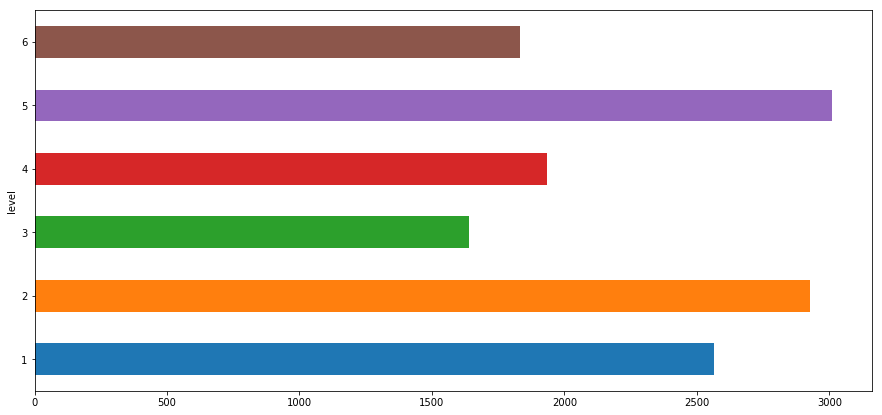

In [9]:
# tabela de contingencia
fig, ax = plt.subplots(figsize=(15,7))
df.groupby("level").size().plot.barh(ax=ax)

Aparantemente existem correlacoes fortes entre os elementos do dataset

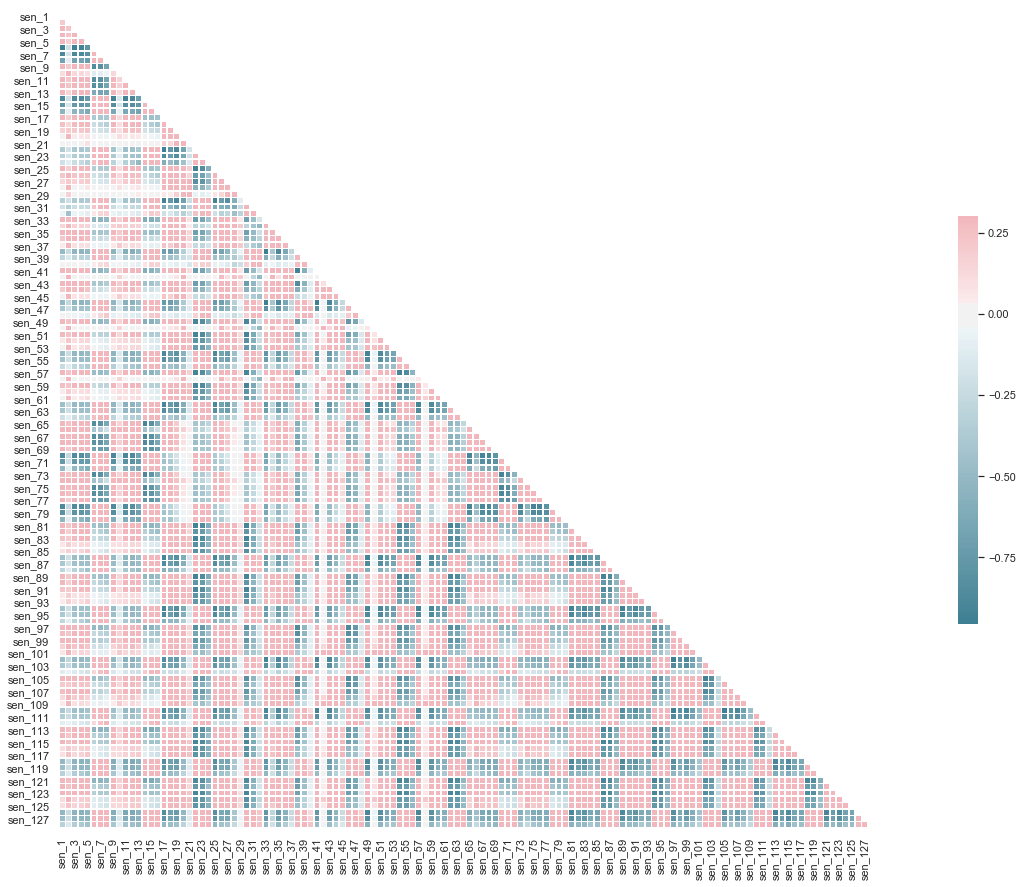

In [10]:
# Plotando as correlacoes
sns.set(style="white")

# Gerando uma matriz de correlacoes
correlacoes = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlacoes, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlacoes, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Aplicando PCA para tratar as correlacoes entre os atributos

In [70]:
# Aplicando PCA

# Dividindo os dados em tX e y
y = df.level
X = df.drop(["Batch", "level"], axis = 1)

# Gerando o PCA
pca = PCA(n_components = 4)

# Aplicando o PCA ao dataset
X = pca.fit_transform(X)

Treinando o conjunto de dados

In [71]:
# Dividindo os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=42)

In [112]:
# Funcao para criar o modelo e avalir o resultado
def model_check(modelo, x_train, y_train, x_test, y_test):
    # treinando o modelo
    modelo.fit(x_train, y_train)
    # prevendo os dados de testes
    pred = modelo.predict(x_test)
    # avaliando o modelo
    acc = accuracy_score(pred, y_test.values) * 100
    confusion = confusion_matrix(pred, y_test.values)
    print("Acuracia do modelo: {0:.0f}%".format(acc))
    print("Confusion Matrix:")
    print(confusion)

Avaliando os modelos de classificacao: Random Forest. ExtraTreesClassifier e LogisticRegression onde Random Forest apresentou melhor resutlado

In [108]:
# Criando um modelo com random forest
model_rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=124)

# avaliando o modelo
model_check(model_rf, x_train, y_train, x_test, y_test)

Acuracia do modelo: 94%
Confusion Matrix
[[729   0   1  15   1   2]
 [  1 786  43   4   0   4]
 [ 14  77 438   1   2   0]
 [ 40   6   2 551   3   5]
 [  0   2   9   2 848   4]
 [  0   2   0   0  22 559]]


In [109]:
# criando um modelo com extraclassifier
model_ec = ExtraTreesClassifier(n_estimators=200, max_depth=4, random_state=124)

# avaliando o modelo
model_check(model_ec, x_train, y_train, x_test, y_test)

Acuracia do modelo: 66%
Confusion Matrix
[[648   4   3 191  10  32]
 [106 846 481 177   5  90]
 [  0   0   0   0   0   0]
 [ 30   1   0 177  17   6]
 [  0  22   9  28 805 173]
 [  0   0   0   0  39 273]]


In [110]:
# criando um modelo com regressao logistica
model_rl = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

# avaliando o modelo
model_check(model_rl, x_train, y_train, x_test, y_test)

Acuracia do modelo: 69%
Confusion Matrix
[[644   3   8 175   3   4]
 [  6 716 292  40   0   0]
 [ 12 142 183  26   2  12]
 [103   0   1 278   2  27]
 [  0   6   9  39 694 158]
 [ 19   6   0  15 175 373]]


Otimizando o modelo de random forest com RandomizedSearchCV

In [89]:
# Otimizando o modelo de Random Forest
model_rf_cv = RandomForestClassifier(random_state = 124)

# Hiperparametros
hiper_rf = {'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# buscando os melhores parametros
rf_random = RandomizedSearchCV(estimator = model_rf_cv, param_distributions = hiper_rf,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# treinando o modelo
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=124, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [90]:
# melhores parametros
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

A melhor versao do modelo apresentanto resultou em uma acuracia de 97%

In [113]:
# Criando um modelo com random forest
model_rf = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1,
                                  max_features = 'auto', max_depth = 60, bootstrap = False, random_state=124)

# avaliando o modelo
model_check(model_rf, x_train, y_train, x_test, y_test)

Acuracia do modelo: 97%
Confusion Matrix:
[[762   0   1  16   1   3]
 [  3 851  26   3   0   0]
 [  1  20 456   1   0   0]
 [ 18   0   1 551   3   3]
 [  0   1   9   2 855   5]
 [  0   1   0   0  17 563]]


### Fim